<a href="https://colab.research.google.com/github/satoru2001/Twitter_Sentiment_Analysis/blob/master/Twitter_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [44]:
!wget --no-check-certificate \
    http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip \
    -O /tmp/SentimentAnalysis.zip

URL transformed to HTTPS due to an HSTS policy
--2020-06-29 06:30:58--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘/tmp/SentimentAnalysis.zip’

/tmp/SentimentAnaly 100%[===================>]  77.59M  19.2MB/s    in 4.8s    

2020-06-29 06:31:04 (16.0 MB/s) - ‘/tmp/SentimentAnalysis.zip’ saved [81363704/81363704]



# Import Libraries

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import os, sys, codecs,zipfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# UnZip the File to /tmp

In [46]:
local_ref = '/tmp/SentimentAnalysis.zip'
zip_ref= zipfile.ZipFile(local_ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Stopwords
- stop words are the words in a sentence which doesnot/have less impact on the sentiment of a sentence
- I took it from [here](https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js)

In [47]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# Reading data from csv

In [48]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('/tmp/training.1600000.processed.noemoticon.csv',header=None, names=cols,encoding = 'latin-1')
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Dropping unwanted Columns

In [49]:
df.drop(['id','date','query_string','user'],axis =1,inplace=True)
print(df.head())
df.sentiment.value_counts()

   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


4    800000
0    800000
Name: sentiment, dtype: int64

In [50]:
df[df.sentiment==4].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


# Checking the Length's of Sentences
- as twitter has a charecter limit of 140(during this data set) getting >350 means we need to clean data

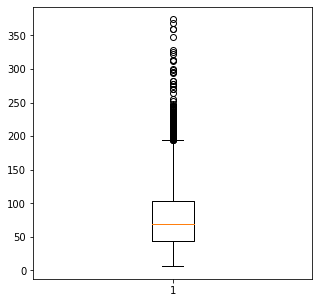

In [51]:
df['pre_clean_length'] = [len(txt) for txt in df.text]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_length)
plt.show()

# Lets See the Data that has charecter_length > 140 

In [52]:
df[df.pre_clean_length>140]

,sentiment,text,pre_clean_length
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
...,...,...,...
1599460,4,@aw16 I must have skipped the &quot;pun&quot; ...,157
1599557,4,@chinkchilla there's this brilliant add-on for...,146
1599835,4,@alexandervelky that's polite version - i only...,145
1599921,4,I just switched back to Opera (using the moi s...,142


# From here onwards we see the different cleaning techniques that we are going to apply on text

## Cleaning the Html data like &quote -> ' 

In [53]:
print(df.text[213])
html_cleaned = BeautifulSoup(df.text[213],'lxml')
html_cleaned.get_text()

Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot;  O-: I like the look of the new transformer movie 


'Awwh babs... you look so sad underneith that shop entrance of "Yesterday\'s Musik"  O-: I like the look of the new transformer movie '

## Removing @usernames

In [54]:
print(df.text[343])
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down 


' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

## Removing URL's

In [55]:
print(df.text[0])
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Removing Bom's

In [56]:
training = df.text[226]
training = training.replace('ï¿½','')

In [57]:
print(training)

Tuesdayll start with reflection n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


# Combining all the above cleaning layers with stop word remover

In [63]:
tokenizer = Tokenizer()
def tweet_cleaner(t):
  soup = BeautifulSoup(t,'lxml')
  souped = soup.get_text()
  clean_1 = re.sub(r' @[A-Za-z0-9]+ | https?://[A-Za-z0-9./]+','',souped)
  try:
    clean_2 = clean_1.replace('ï¿½','')
  except:
    clean_2 = clean_1
  letters_only = re.sub("[^a-zA-Z]",' ',clean_2)
  lower_case = letters_only.lower()
  final_clean = re.sub('\s+',' ',lower_case)
  final_result = ' '.join([word for word in final_clean.split() if word not in stopwords])
  return final_result.strip()

test_result = []
testing = df.text[:100]
for i in testing:
  test_result.append(tweet_cleaner(i))
test_result

['switchfoot awww s bummer shoulda got david carr third day d',
 'upset can t update facebook texting might cry result school today also blah',
 'kenichan dived many times ball managed save rest go bounds',
 'whole body feels itchy like fire',
 'nationwideclass no s not behaving m mad can t see',
 'kwesidei not whole crew',
 'need hug',
 'loltrish hey long time no see yes rains bit bit lol m fine thanks s',
 'tatiana k nope didn t',
 'twittera que muera',
 'spring break plain city s snowing',
 'just re pierced ears',
 'caregiving couldn t bear watch thought ua loss embarrassing',
 'octolinz counts idk either never talk anymore',
 'smarrison ve first didn t gun not really though zac snyder s just doucheclown',
 'iamjazzyfizzle wish got watch miss premiere',
 'hollis death scene will hurt severely watch film wry directors cut not now',
 'file taxes',
 'lettya ahh ive always wanted see rent love soundtrack',
 'fakerpattypattz oh dear drinking forgotten table drinks',
 'alydesigns day didn

# Applying the Cleaner filter to our Tweets
## It will take ~10 minutes

In [64]:
print("Cleaning and parsing the tweets..\n")
clean_tweet_texts = []
for i in range(len(df.text)):
  clean_tweet_texts.append(tweet_cleaner(df.text[i]))
  if (i%10000)==0:
    print (str(i)+'Tweets Completed')

Cleaning and parsing the tweets..

0Tweets Completed
10000Tweets Completed
20000Tweets Completed
30000Tweets Completed
40000Tweets Completed
50000Tweets Completed
60000Tweets Completed
70000Tweets Completed
80000Tweets Completed
90000Tweets Completed
100000Tweets Completed
110000Tweets Completed
120000Tweets Completed
130000Tweets Completed
140000Tweets Completed
150000Tweets Completed
160000Tweets Completed
170000Tweets Completed
180000Tweets Completed
190000Tweets Completed
200000Tweets Completed
210000Tweets Completed
220000Tweets Completed
230000Tweets Completed
240000Tweets Completed
250000Tweets Completed
260000Tweets Completed
270000Tweets Completed
280000Tweets Completed
290000Tweets Completed
300000Tweets Completed
310000Tweets Completed
320000Tweets Completed
330000Tweets Completed
340000Tweets Completed
350000Tweets Completed
360000Tweets Completed
370000Tweets Completed
380000Tweets Completed
390000Tweets Completed
400000Tweets Completed
410000Tweets Completed
420000Tweets 

# Saving it to a .csv file for further use

In [65]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['value'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

# Designing and Training our model
We load the pretrained Glove word Embeddings

In [66]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.twitter.27B.zip \
    -O /tmp/glove_twitter.zip

--2020-06-29 07:16:49--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-06-29 07:16:49--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-06-29 07:16:49--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

# Unzipping

In [67]:
loc_ref = '/tmp/glove_twitter.zip'
zip_ref= zipfile.ZipFile(loc_ref,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Defining Variables

In [68]:
embedding_dim = 100
max_len = 20
trunc_type = 'post'
padding_type = 'post'
oov_token = "<oov>"
test_portion = 0.1
corpus = []
num_sentences = 0

# Reading from CSV we created above

In [69]:
with open('clean_tweet.csv') as csvfile:
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  for row in reader:
    list_item = []
    list_item.append(row[1])
    if row[2]=='0':
      list_item.append(0)
    else:
      list_item.append(1)
    num_sentences+=1
    corpus.append(list_item)


In [70]:
print(num_sentences)
print(len(corpus))
print(corpus[0])

1600000
1600000
['switchfoot awww s bummer shoulda got david carr third day d', 0]


# Tokenizing,Splitting and saperating Sentences and labels

In [71]:
sentences = []
labels = []
random.shuffle(corpus)
for i in range(num_sentences):
  sentences.append(corpus[i][0])
  labels.append(corpus[i][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padding = pad_sequences(sequences,maxlen=max_len,padding = padding_type,truncating=trunc_type)

split = int(num_sentences*test_portion)

train_seq = padding[split:]
train_label = labels[split:]

test_seq = padding[:split]
test_label = labels[:split]

In [72]:
print(vocab_size)
print(word_index['shoulda'])
print(len(test_label))

563359
3422
160000


# Extracting 100 dimension embedded matrix from Glove and creating a word,vector Dictionary

In [73]:
embeddings_index = {}
with open('/tmp/glove.twitter.27B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    if word.isalpha():
      embeddings_index[word] = np.array(values[1:],dtype='float32')

# Converting Tokanized sentences to embedded matrix

In [74]:
embedding_matrix = np.zeros((vocab_size+1,embedding_dim))
for word ,i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

# Model

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length=max_len,
                                                       weights=[embedding_matrix],trainable=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           56336000  
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 100)           400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 64)            19264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 64)             256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 64)            

In [79]:
from tensorflow.keras.backend import clear_session
clear_session()
train_sent = np.array(train_seq)
train_lab = np.array(train_label)
valid_sent = np.array(test_seq)
valid_lab = np.array(test_label)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])
num_epochs = 5
history = model.fit(train_sent, train_lab, epochs=num_epochs, verbose=1,validation_data=(valid_sent,valid_lab))

Epoch 1/5
45000/45000 [==============================] - 641s 14ms/step - loss: 0.5020 - accuracy: 0.7547 - val_loss: 0.4477 - val_accuracy: 0.7880
Epoch 2/5
45000/45000 [==============================] - 636s 14ms/step - loss: 0.4809 - accuracy: 0.7698 - val_loss: 0.4403 - val_accuracy: 0.7936
Epoch 3/5
45000/45000 [==============================] - 637s 14ms/step - loss: 0.4759 - accuracy: 0.7736 - val_loss: 0.4364 - val_accuracy: 0.7967
Epoch 4/5
45000/45000 [==============================] - 634s 14ms/step - loss: 0.4727 - accuracy: 0.7755 - val_loss: 0.4338 - val_accuracy: 0.7985
Epoch 5/5
45000/45000 [==============================] - 635s 14ms/step - loss: 0.4711 - accuracy: 0.7768 - val_loss: 0.4325 - val_accuracy: 0.7991


In [80]:
model.evaluate(valid_sent,valid_lab)

5000/5000 [==============================] - 30s 6ms/step - loss: 0.4325 - accuracy: 0.7991


[0.4324914515018463, 0.7990562319755554]

# Plot the curves

<Figure size 432x288 with 0 Axes>

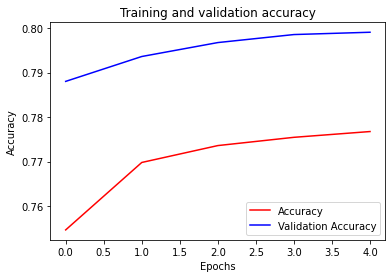

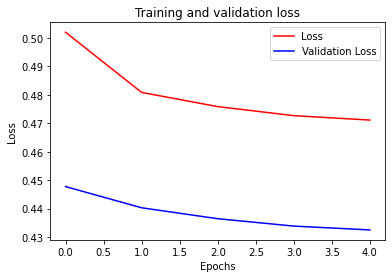

<Figure size 432x288 with 0 Axes>

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()




In [95]:
y_pred = model.predict(valid_sent)
y_pred = y_pred.flatten()
for i in range(len(y_pred)):
  if y_pred[i]>=0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0
y_pred = np.array(y_pred,dtype = 'int')
y_truth = valid_lab.flatten()
print(y_pred[:10])
print(y_truth[:10])

[0 1 1 0 1 1 0 1 1 0]
[0 1 1 0 1 1 1 1 1 0]


# Confusion Matrix

In [96]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score
cnf_matrix = confusion_matrix(y_truth,y_pred)
score = f1_score(y_truth,y_pred)
print('Confusion Matrix:')
print(cnf_matrix)
print('F1 Score:'+str(score))

Confusion Matrix:
[[65165 15009]
 [17142 62684]]
F1 Score:0.7958912893047823
